**Brown & Philips et. al "Semi-automated production of cell-free biosensors" Data Analysis**

Compile excel an excel spreadsheet that processes kinetic data from biosensor experiment. Reaction data was manually normalized and placed in an excel spreadsheet before python processing. Output provides half max signal, max signal, and time to half max signal. 

In [1]:
import pandas as pd
import numpy as np

# Load the Excel spreadsheet, Change directory path for different data
excel_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_FRS_Compiled_Data.xlsx'

# Open the Excel file
xls = pd.ExcelFile(excel_file)

# Create a new Excel writer to save the outputs
output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Output_FRS_Compiled_Data.xlsx'
output_writer = pd.ExcelWriter(output_file, engine='xlsxwriter')

# Loop through each sheet in the Excel file
for sheet_name in xls.sheet_names:
    print(f"Processing sheet: {sheet_name}")

    # Read the data from the current sheet
    data = pd.read_excel(xls, sheet_name=sheet_name)

    # Determine column headers
    column_headers = data.columns.tolist()
    time_column = column_headers[0]  # Assuming the first column is the time column

    # Convert columns to numeric values
    for column in column_headers[1:]:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    # Find the minimum and maximum signal values, and calculate half-maximum value for each column
    half_max_values = {}
    max_values = {}
    time_to_half_max = {}
    for column in column_headers[1:]:
        min_signal = data[column].min()
        max_signal = data[column].max()
        half_max_signal = (min_signal + max_signal) / 2

        signal_values = data[column].values
        time_values = data[time_column].values

        # Initialize variables
        half_max_time = None
        max_signal_value = max_signal  # Initialize with the maximum value
        prev_signal = signal_values[0]
        crossing_indices = []

        # Loop through the data to find crossing indices and calculate the maximum signal
        for i in range(1, len(signal_values)):
            if signal_values[i] > max_signal_value:
                max_signal_value = signal_values[i]
            if prev_signal <= half_max_signal <= signal_values[i] or prev_signal >= half_max_signal >= signal_values[i]:
                crossing_indices.append(i)

            prev_signal = signal_values[i]

        if len(crossing_indices) > 0:
            last_crossing_index = crossing_indices[-1]
            x1 = time_values[last_crossing_index - 1]
            x2 = time_values[last_crossing_index]
            y1 = signal_values[last_crossing_index - 1]
            y2 = signal_values[last_crossing_index]
            half_max_time = x1 + ((x2 - x1) * (half_max_signal - y1) / (y2 - y1))

        half_max_values[column] = half_max_signal
        max_values[column] = max_signal_value
        time_to_half_max[column] = half_max_time

    # Create dataframes from the dictionaries
    half_max_df = pd.DataFrame(list(half_max_values.items()), columns=['Column', 'Half-Maximum Signal Value'])
    max_df = pd.DataFrame(list(max_values.items()), columns=['Column', 'Maximum Signal Value'])
    time_to_half_max_df = pd.DataFrame(list(time_to_half_max.items()), columns=['Column', 'Time to Half-Maximum'])

    # Save the dataframes to the Excel file
    half_max_df.to_excel(output_writer, sheet_name=f"{sheet_name}_Half_Max", index=False)
    max_df.to_excel(output_writer, sheet_name=f"{sheet_name}_Max", index=False)
    time_to_half_max_df.to_excel(output_writer, sheet_name=f"{sheet_name}_Time_to_Half_Max", index=False)

# Save the Excel file with the outputs
output_writer.save()
print(f"Results saved to {output_file}")

Processing sheet: Sheet1
Results saved to /Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Output_FRS_Compiled_Data.xlsx


**Categorization of 384 well plate based on reaction induction conditions**

Takes the compiled data and categorizes the wells of a 384 well plate, in this experiment, rehydration was carried out using an interleaved signal format with High (H) concentration NaF (1mM), Medium (M) concentration NaF (0.25mM), and Low (L) concentration NaF (0 mM). Four 96 well plates were constructed using the rehydration format HML, LHM, MLH, then HML, where these concentrations of NaF were added to each column of the 96 well plate repeating 4 times per plate (ex. column 1=H, 2=M, 3=L, 4=H, 5=M, 6=L, until the plate is fully rehydrated).This was to account for distribution effects imparted by the robot. All 4 96 well plates are then plated in a 384 well plate in quadrants.  The code used here then categorizes each biosensor reaction based on their 384 well plate position given a label H, M, or L, depending on the rehydration condition. This output can then be used to look at distributions of each hydrated condition graphically, using H, M, or L to distribute the populations. 

In [2]:
import pandas as pd

# Load the previously generated output file
output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Output_FRS_Compiled_Data.xlsx'
output_reader = pd.ExcelFile(output_file)

# Create a new Excel writer to save the updated data
updated_output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Updated_Output_FRS_Compiled_Data.xlsx'
output_writer = pd.ExcelWriter(updated_output_file, engine='xlsxwriter')

# Define a function to categorize columns based on the pattern
def categorize_column(column_name):
    if len(column_name) >= 2 and column_name[0] in 'ABCDEFGH':
        column_number = column_name[1:]
        if column_number.isdigit() or (column_number[:-1].isdigit() and int(column_number[:-1]) >= 10):
            column_number = int(column_number)
            if (column_number >= 1 and column_number <= 12):
                if column_number % 3 == 1:
                    return 'H'
                elif column_number % 3 == 2:
                    return 'M'
                else:
                    return 'L'
            elif (column_number >= 13 and column_number <= 24):
                if column_number % 3 == 1:
                    return 'L'
                elif column_number % 3 == 2:
                    return 'H'
                else:
                    return 'M'
    elif len(column_name) >= 2 and column_name[0] in 'IJKLMNOP':
        column_number = column_name[1:]
        if column_number.isdigit() or (column_number[:-1].isdigit() and int(column_number[:-1]) >= 10):
            column_number = int(column_number)
            if (column_number >= 1 and column_number <= 12):
                if column_number % 3 == 1:
                    return 'M'
                elif column_number % 3 == 2:
                    return 'L'
                else:
                    return 'H'
            elif (column_number >= 13 and column_number <= 24):
                if column_number % 3 == 1:
                    return 'H'
                elif column_number % 3 == 2:
                    return 'M'
                else:
                    return 'L'
    return ''

# Loop through each sheet in the output file
for sheet_name in output_reader.sheet_names:
    df = output_reader.parse(sheet_name)

    # Add a new column with category labels based on the pattern
    df['Category'] = df['Column'].apply(categorize_column)

    # Save the updated data to a new sheet in the output_writer
    df.to_excel(output_writer, sheet_name=sheet_name, index=False)

# Save the updated Excel file with the category labels
output_writer.save()
print(f"Updated results saved to {updated_output_file}")

Updated results saved to /Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Updated_Output_FRS_Compiled_Data.xlsx


**WELL POSITION PLOTS** To assess distribution consistency accross the well positions over the four plates. This can be affected in part by experimenter rehydration error. Plots go from wells A1->P24

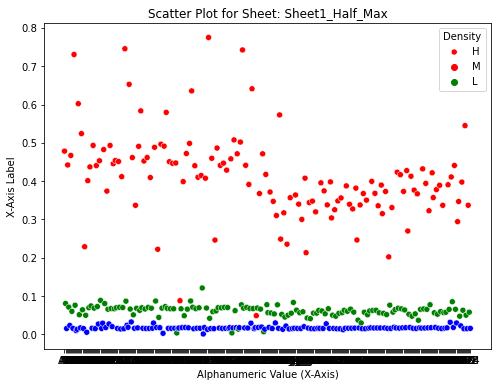

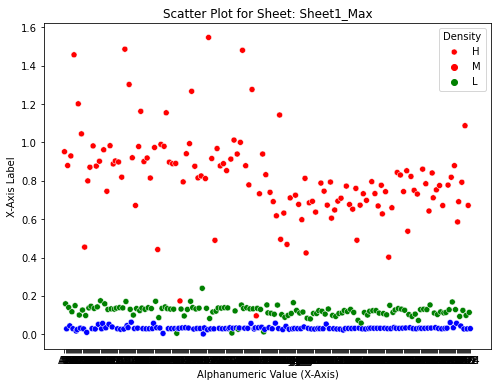

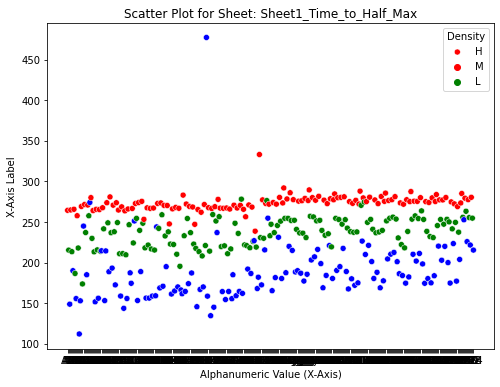

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Updated_Output_FRS_Compiled_Data.xlsx'
output_reader = pd.ExcelFile(output_file)

for sheet_name in output_reader.sheet_names:
    # Read the sheet into a DataFrame
    df = output_reader.parse(sheet_name, header=0)  # Assuming the first row is a header

    # Check if there are at least 3 columns
    if len(df.columns) < 3:
        print(f"Sheet {sheet_name} does not have at least 3 columns. Skipping.")
        continue

    # Extract the second and third columns
    x = df.iloc[:, 1]  # Second column
    y = df.iloc[:, 2]  # Third column

    # Extract the alphanumeric values (e.g., 'A1', 'A2', 'B1')
    alphanumeric = df.iloc[:, 0]  # Assuming the alphanumeric values are in the first column

    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a horizontal scatter plot with X-axis based on column one and 'H,' 'M,' and 'L' labels
    sns.scatterplot(x=alphanumeric, y=x, hue=y, palette={'H': 'red', 'M': 'green', 'L': 'blue'})

    # Customize the plot
    ax.set_xlabel('Alphanumeric Value (X-Axis)')
    ax.set_ylabel('X-Axis Label')  # Switched axis label
    ax.set_title(f'Scatter Plot for Sheet: {sheet_name}')
    ax.legend(title='Density', labels=['H', 'M', 'L'])

    # Show or save the plot as desired
    plt.show()

**Swarm and Violing Plots** Shows the distribution of the populations separated by H, M, or L concentration conditions

Generates and saves swarm plots as svg files in directory

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Updated_Output_FRS_Compiled_Data.xlsx'
output_reader = pd.ExcelFile(output_file)

# Custom color in RGB format (e.g., (0.1, 0.2, 0.5) for a blueish color)
swarm_color_rgb = (0.53333, 1, 0.6862745098039216)

output_folder = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2'  # Define the output folder path

for sheet_name in output_reader.sheet_names:
    # Read the sheet into a DataFrame
    df = output_reader.parse(sheet_name, header=0)  # Assuming the first row is a header

    # Check if there are at least 3 columns
    if len(df.columns) < 3:
        print(f"Sheet {sheet_name} does not have at least 3 columns. Skipping.")
        continue

    # Extract the second and third columns
    y = df.iloc[:, 1]  # Second column
    x = df.iloc[:, 2]  # Third column

    # Extract the categorical labels
    labels = df.iloc[:, 2]  # Assuming the categorical labels are in the third column

    # Set style to gray
    sns.set(style="whitegrid", palette="bone")

    # Define the desired order of categories
    hue_order = ['L', 'M', 'H']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(3, 2))

    # Create a swarmplot for distribution of points with specified hue order
    sns.swarmplot(x=x, y=y, hue=labels, hue_order=hue_order, color=swarm_color_rgb, alpha=1, size =3,  ax=ax, dodge = False)

    plt.title(f'Swarm Plot: {sheet_name}')
    plt.xlabel('NaF Condition')
    plt.ylabel('MEF (uM FITC)')
    plt.legend(title='Labels')

    # Save the plot as an SVG file
    output_filename = os.path.join(output_folder, f'{sheet_name}_swarm_plot.svg')
    plt.savefig(output_filename, format='svg', bbox_inches='tight')
    plt.close()  # Close the current figure to release memory

/Users/dylan/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dylan/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 67.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dylan/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 85.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dylan/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/dylan/opt/anaconda3/lib/python3.8/site-packages/sea

Generates violin plots for the experimental data

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Updated_Output_FRS_Compiled_Data.xlsx'
output_reader = pd.ExcelFile(output_file)

# Custom color in RGB format (e.g., (0.1, 0.2, 0.5) for a blueish color)
outline_color_rgb = (0.53333, 1, 0.6862745098039216)

output_folder = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2'  # Define the output folder path

for sheet_name in output_reader.sheet_names:
    # Read the sheet into a DataFrame
    df = output_reader.parse(sheet_name, header=0)  # Assuming the first row is a header

    # Check if there are at least 3 columns
    if len(df.columns) < 3:
        print(f"Sheet {sheet_name} does not have at least 3 columns. Skipping.")
        continue

    # Extract the second and third columns
    y = df.iloc[:, 1]  # Second column
    x = df.iloc[:, 2]  # Third column

    # Extract the categorical labels
    labels = df.iloc[:, 2]  # Assuming the categorical labels are in the third column

    # Set style to gray
    sns.set(style="whitegrid", palette="bone")

    # Define the desired order of categories
    hue_order = ['L', 'M', 'H']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(3, 2))

    # Create a violin plot for distribution of points with specified hue order
    sns.violinplot(x=x, y=y, hue=labels, hue_order=hue_order, ax=ax, dodge=False,
                   linewidth=1.5, inner=None, palette=[outline_color_rgb], 
                   edgecolor=outline_color_rgb)

    plt.title(f'Violin Plot: {sheet_name}')
    plt.xlabel('NaF Condition')
    plt.ylabel('MEF (uM FITC)')
    plt.legend(title='Labels')

    # Save the plot as an SVG file
    output_filename = os.path.join(output_folder, f'{sheet_name}_violin_plot.svg')
    plt.savefig(output_filename, format='svg', bbox_inches='tight')
    plt.close()  # Close the current figure to release memory

**Claculating Percentages Above Cutoffs**

Generates an excel spreadsheet with the fraction of reactions above the given cutoffs. The thresholds were experimental data were given as Signal > Max Value of Signal in L, and Signal > 0.5 uM FITC for the experimental conditions. For the expected values, to meet Signal > Max Value of Signal in L both H = 1mM NaF and M = 0.25 mM NaF over the total number of reactions (H+M+L) is considered expected. For the 0.5uM FITC threshold, H=1mM NaF is expected to achieve this fluorescence under the given conditions, and the fraction is given as (H/(H+M+L))

In [20]:
import pandas as pd

# Load the Excel file
output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_Updated_Output_FRS_Compiled_Data.xlsx'

# Read the "max signal" sheet
df = pd.read_excel(output_file, sheet_name="Sheet1_Max")

# First calculation: Fraction of data higher than max value of category L
# Get the maximum value of the category 'L'
max_value_L = df[df['Category'] == 'L']['Maximum Signal Value'].max()

# Calculate the fraction of data in "Maximum Signal Values" higher than max_value_L
fraction_higher = (df['Maximum Signal Value'] > max_value_L).mean()

# Calculate the expected fraction (all H and M values over the total)
fraction_HM = df[df['Category'].isin(['H', 'M'])].shape[0] / df.shape[0]

# Create a DataFrame with the calculated values for the first calculation
data1 = pd.DataFrame({
    'Fraction Higher': [fraction_higher],
    'Expected Fraction (H and M over Total)': [fraction_HM]
})

# Second calculation: Fraction of data above 0.5
# Calculate the fraction of data in "Maximum Signal Values" higher than 0.5
fraction_above_0_5 = (df['Maximum Signal Value'] > 0.5).mean()

# Calculate the expected fraction (H over the total of H, M, and L)
total_HML = df[df['Category'].isin(['H', 'M', 'L'])].shape[0]
fraction_H = df[df['Category'] == 'H'].shape[0] / total_HML

# Create a DataFrame with the calculated values for the second calculation
data2 = pd.DataFrame({
    'Fraction Above 0.5': [fraction_above_0_5],
    'Expected Fraction (H over H+M+L)': [fraction_H]
})

# Save the two DataFrames to a new Excel file with different sheets
new_output_file = '/Users/dylan/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/77_CBC_Objective_3_Sensor_Scaleup/Supplemental_Information/Supporting Data and Python Files/Supp_Data_Figure_2/Figure_2_FRS_Percent_Expected_vs_Actual.xlsx'
with pd.ExcelWriter(new_output_file) as writer:
    data1.to_excel(writer, sheet_name='Fraction_Higher', index=False)
    data2.to_excel(writer, sheet_name='Above_0_5', index=False)

print("New Excel file with both sets of fractions created successfully.")


New Excel file with both sets of fractions created successfully.
